We consider the augmented formulation of the same problem as before
$$
    \left\{ \begin{array}{ll}
    \displaystyle \min_{x,u} x^0(t_f) \\[1em]
    \text{s.c.}~\dot x^0(t) = x_1(t), & t\in [t_0, t_f]~\mathrm{a.e.}, \\[0.5em]
    \phantom{\mathrm{s.c.}~} \dot x_1(t) = u(t), & t\in [t_0, t_f]~\mathrm{a.e.}, \\[0.5em]
    \phantom{\mathrm{s.c.}~} u(t) \in [-1,1], & t\in [t_0, t_f], \\[0.5em]
    \phantom{\mathrm{s.c.}~} x(t_0) = x_0, \quad x_1(t_f) = x_f,
    \end{array} \right.
$$

with fixed $x_0$, $t_0$, $x_f$ and $t_f$, and where $x = (x^0, x_1)$. The augmented Hamiltonian of this problem is given by 

$$ 
    H(x,p) = p^0 x_1 + \lvert p_1 \rvert,
$$ 

where $p = (p^0, p_1)$ is the augmented costate, composed by the costate $p_1$ associated to the state $x_1$ and multiplier $p^0$ associated to the cost $x^0$ which is no longer fixed to $-1$. The flow $\varphi$ associated to the true Hamiltonian $H$ is computed thanks to the $\texttt{flow}$ and the $\texttt{Hamiltonian}$ functions.

The general shooting function $S \colon \mathbb R^2 \to \mathbb R$ associated to this Hamiltonian is defined by 

$$
    S(p_0) = \pi_x \big( \varphi(t_0, x_0, p_0, t_f) \big),
$$

where $\pi_x(x^0, x_1, p^0, x_1) = x_1$ is still the state projection. 

We are interested in two normalization of this shooting function, thanks to the homogeneity of the BC-extremals on the augmented costate, which are 

$$
    S_1(p_0) = S(-1, p_0) \qquad \text{and} \qquad S_2(p_0) = S \big( \eta(p), p_0 \big)
$$

where the function $\eta \colon [-1, 1] \to \mathbb R$ is defined by 

$$
    \eta(p) = -\sqrt{ 1 - p^2}.
$$

The following code creates and plots these shooting functions. 

  Activating project at `c:\Users\uiv02757\OneDrive - Vitesco Technologies\git_repos\preconditioning\resources`
┌ Info: Saved animation to C:\Users\uiv02757\AppData\Local\Temp\jl_uF4x618Z0F.gif
└ @ Plots C:\Users\uiv02757\.julia\packages\Plots\du2dt\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\uiv02757\\AppData\\Local\\Temp\\jl_uF4x618Z0F.gif")
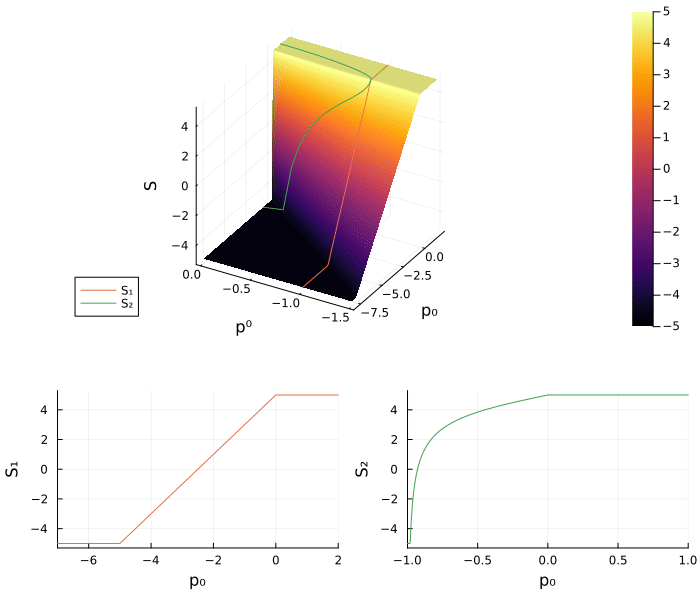

In [1]:
using Pkg
Pkg.activate(".")
using OptimalControl
using Plots
using ForwardDiff
using DifferentialEquations
using MINPACK
using Statistics

global α = 1

function condition(z, t, integrator)                        # event when condition(z,t,integrator) == 0
    x⁰,x,p⁰,p = z
    return p
end
function affect!(integrator)                                # action when condition == 0 
    global α = -α
    nothing
end

cb = ContinuousCallback(condition, affect!)                 # callback 
H(x, p) = p[1] * x[2] + α * p[2]
ϕ_ = Flow(Hamiltonian(H), callback = cb)                    # flow with maximizing control 

function ϕ(t0, x0, p0, tf; kwargs...)  
    if p0[2] == 0
        global α = -sign(p0[1])
    else
        global α = sign(p0[2])
    end
    return ϕ_(t0, x0, p0, tf; kwargs...)
end

function ϕ((t0, tf), x0, p0; kwargs...)                     # flow for plot
    if p0[2] == 0
        global α = -sign(p0[1])
    else
        global α = sign(p0[2])
    end
    return ϕ_((t0, tf), x0, p0; kwargs...)
end

t0 = 0                                                          # initial time
x0 = [0,0]                                                      # initial augmented state
tf = 5                                                          # final time
xT = 0                                                          # final state

π((x,p)) = x[2]                                                 # projection on state space
η(p0) = -sqrt.(1 - p0.^2)                                       # function η(⋅)

S(p0) = π( ϕ(t0, x0, p0, tf) ) - xT                             # general hooting function

S₁(p0) = S([-1, p0])                                            # normalization 1
S₂(p0) = abs(p0) < 1 ? S([η(p0), p0]) : sign(p0)*tf - xT        # normalization 2

# Plot
plt_S1 = plot(range(-7, 2, 500), S₁ , color = 2, label = "")
plot!(xlabel = "p₀", ylabel = "S₁", xlim = [-7,2])

plt_S2 = plot(range(-1, 1, 500), S₂, color = 3)
plot!(xlabel = "p₀", ylabel = "S₂", xlim = [-1,1], legend=false)

S_(p⁰, p) = S([p⁰, p])
plt_S = surface(range(0, -1.5, 100), range(-8, 2, 100), S_, camera = (30,30))
surface!(xlabel = "p⁰", ylabel = "p₀", zlabel = "φₓ", xflip = true)
plot3d!(-1*ones(100), range(-8, 2, 100), S₁.(range(-8, 2, 100)), label = "S₁")
plot3d!(η.(range(-1, 1, 100)), range(-1, 1, 100), S₂.(range(-1, 1, 100)), label = "S₂")

plt_S12 = plot(plt_S1, plt_S2, layout = (1,2))
plt_total = plot(plt_S, plt_S12, layout = grid(2,1, heights = [2/3, 1/3]), size=(700, 600))

@gif for i ∈ [range(30, 90, 50); 90*ones(25); range(90, 30, 50); 30*ones(25)]
    plot!(plt_total[1], camera=(i,i), 
        zticks = i==90 ? false : true,
        zlabel = i==90 ? "" : "S" )
end

As done before, we use the solver $\texttt{hybrd1}$ from the $\texttt{MINPACK.jl}$ package to find a zero of $S_2$.

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     3.845299e+00     0.000000e+00         0.150000
     2     5.000000e+00     1.559496e+00         4.483000
     3     5.000000e+00     4.983094e-01         0.000000
     4     5.000000e+00     4.983094e-01         0.001000
     5     5.000000e+00     4.983094e-01         0.000000
     6     2.825589e+00     9.417471e-02         0.000000
     7     3.275582e+00     5.569993e-02         0.001000
     8     1.835694e+00     1.605481e-02         0.000000
     9     5.000000e+00     4.108358e-02         0.000000
    10     8.767661e-01     2.198078e-02         0.000000
    11     1.052824e+00     2.476848e-03         0.000000
    12     2.252319e-01     7.373618e-04         0.001000
    13     6.733089e-02     6.111140e-05         0.000000
    14     4.061534e-03     3.236777e-06         0.000000
    15     6.974839e-05     1.047584e-08         0.000000
    16     7.333033

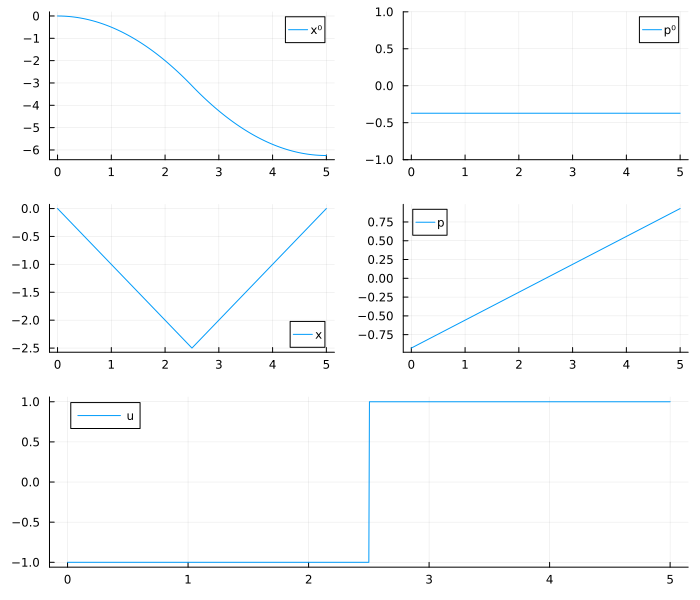

In [2]:
global iterate_S2 = Vector{Float64}()                       # global vector to store iterates of the solver

function S₂!(s₂, ξ)                                         # intermediate function
    push!(iterate_S2, ξ[1])                                 # stock the iterate
    return (s₂[:] .= S₂(ξ[1]); nothing)                     
end

JS₂(ξ) = ForwardDiff.jacobian(p0 -> [S₂(p0[1])], ξ)         # compute jacobian by forward differentiation
JS₂!(js₂, ξ) = (js₂[:] .= JS₂(ξ); nothing)                  # intermediate function

ξ = [-0.5]                                                  # initial guess
p0_sol = fsolve(S₂!, JS₂!, ξ, show_trace = true)            # solve
println(p0_sol)                                             # print solution
sol = ϕ((t0, tf), x0, [η(p0_sol.x[1]), p0_sol.x[1]], 
    saveat=range(t0, tf, 500))                              # get optimal trajectory

# plot
t = sol.t
x⁰ = [sol.u[i][1] for i in 1:length(sol.u)]
x  = [sol.u[i][2] for i in 1:length(sol.u)]
p⁰ = [sol.u[i][3] for i in 1:length(sol.u)]
p  = [sol.u[i][4] for i in 1:length(sol.u)]
u = sign.(p)

plt_x⁰ = plot(t, x⁰, label = "x⁰")
plt_x  = plot(t, x , label = "x" )
plt_p⁰ = plot(t, p⁰, label = "p⁰", ylim=[-1,1])
plt_p  = plot(t, p , label = "p" )
plt_u  = plot(t, u,  label = "u" )

plt_xp = plot(plt_x⁰, plt_p⁰, plt_x, plt_p, layout=(2, 2))
plot(plt_xp, plt_u, layout = grid(2,1, heights = [2/3, 1/3]), size=(700, 600))

The goal is now to use the geometric preconditioning method proposed in [mettre article]. For this purpose, the first step is to create some points in the boundary of the accessible augmented set, and to fit an ellipse on these points. 

The second step is to create the linear diffeomorphism $\phi \colon \mathbb R^2 \to \mathbb R^2, (x^0,x_1) \to Ax + B$ that transforms the fitted ellipse into the unit circle, and that satisfy the condition 

$$
    \frac{\partial \phi}{\partial x^0} = k e_1, 
$$

with $k>0$ and $e_1 = (1,0)$. In this context, we denote 

$$
    A = \left( \begin{array}{cc} k & A_{x^0} \\ 0 & A_{x_1} \end{array} \right)
    \qquad \text{and} \qquad 
    B = \left( \begin{array}{c} B_{x^0} \\ B_{x_1} \end{array} \right).
$$
 This diffeomorphism is given from the semi-axis $a,b >0$, the angle $\theta \in [0, \frac{\pi}{2}[$ between the semi-axis $b$ and the $x$-axis, and the center $c \in \mathbb R^2$ by 

$$ 
    \phi(x) = r(-\beta_0) s(a^{-1}, b^{-1}) r(\theta) (x - c),
$$

where $r$ and $s$ correspond respectively to the rotation and the scale matrix, defined by 

$$
    r(\theta) = \left( \begin{array}{cc} \phantom - \cos(\theta) & \sin(\theta) \\ -\sin(\theta) & \cos(\theta) \end{array} \right)
    \qquad \text{and} \qquad
    s(a,b) = \left( \begin{array}{cc} a & 0 \\ 0 & b \end{array} \right),
$$
and where $\beta_0 = \arctan \left(\frac{a \sin(\theta)}{b \cos(\theta)} \right)$. 

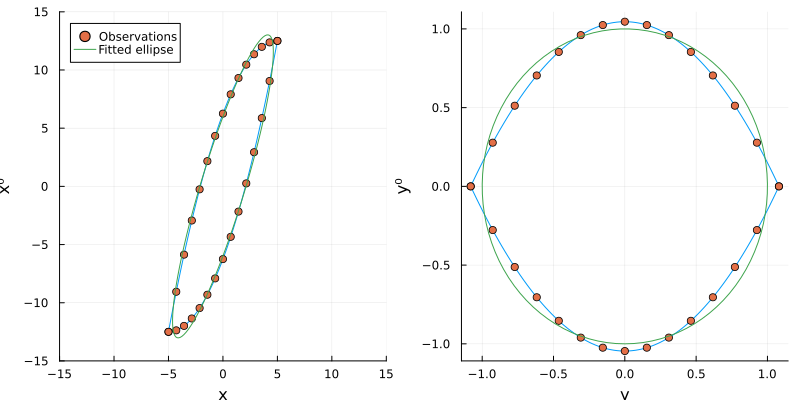

In [3]:
function fit_ellipse(x, y)
    M = hcat(x.^2, x.*y, y.^2, x, y)            # quadratic form of ellipse
    p = M\ones(length(x))                       # fit parameters for the ellipse
    A, B, C, D, E = p
    F = -1.0
    # calculate the parameters from quadratic:
    Δ = B^2 - 4*A*C
    Λ = (A-C)^2 + B^2
    b, a = [-sqrt(clamp( 2*(A*E^2 + C*D^2 - B*D*E + Δ*F)*
            ( (A+C) + op(sqrt(Λ)) ), 0, Inf)) / Δ   for op in (+, -)]
    θ = atan(-B, C-A)/2
    c = [(2*C*D - B*E)/Δ, (2*A*E - B*D)/Δ]
    return a, b, -θ+Base.π/2, c
end

n = 15                                              # number of points for fit : 2n
n_ = 100                                            # number of points for plot: 2n_
p0 = [[[-1, i] for i ∈ range(-tf, 0, n)];           # initial costate for fit
      [[1, i] for i ∈ range(tf, 0, n)]]     
p0_ = [[[-1, i] for i ∈ range(-tf, 0, n_)];         # initial costate for plot
       [[1, i] for i ∈ range(tf, 0, n_)]]

x = zeros(2, 2*n); p = zeros(2,2*n)                 # init final state and costate
x_ = zeros(2, 2*n_); p_ = zeros(2, 2*n_)
for i = 1:length(p0)
    x[:,i], p[:,i] = ϕ(t0, x0, p0[i], tf)           # compute flow for fit
end
for i = 1:length(p0_)
    x_[:,i], p_[:,i] = ϕ(t0, x0, p0_[i], tf)        # compute flow for plot
end

a, b, θ, c = fit_ellipse(x[1,:], x[2,:])            # fit ellipse
r(β) = [[cos(β), sin(β)] [-sin(β), cos(β)]]         # 2x2 rotation matrix
s(a,b) = [[a,0] [0,b]]                              # 2x2 scale matrix
β = range(-Base.π, Base.π; length = 100)            # angle for plot ellipse
xₑ = r(-θ)*s(a,b)*
    transpose(reduce(hcat,[sin.(β), cos.(β)])).+c   # points of the ellipse

# construction of the linear diffeomorphism φ(x) = Ax * B
d = (a*sin(θ))/(b*cos(θ)); β₀ = atan(d)             # intermediate values
A = r(-β₀)*s(1/a,1/b)*r(θ); B = -A*c                # calculate A and B
φ(x) = A*x .+ B                                     # function φ

y = φ(x); y_ = φ(x_); yₑ = φ(xₑ)                    # compute φ on x, x_ and xₑ

# plot
plt_x = plot(x_[2,:], x_[1,:], label = "")
scatter!(x[2,:], x[1,:], label="Observations", legend = :topleft)
plot!(xₑ[2,:], xₑ[1,:], label = "Fitted ellipse")
plot!(xlim = [-15,15], ylim = [-15,15], xlabel = "x", ylabel = "x⁰")

plt_y = plot(y_[2,:], y_[1,:], label = "")
scatter!(y[2,:], y[1,:], label="")
plot!(yₑ[2,:], yₑ[1,:], label = "")
plot!( xlabel = "y", ylabel = "y⁰")

plot(plt_x, plt_y, layout = (1,2), size=(800, 400))

The general shooting function $T \colon \mathbb R^2 \to \mathbb R$ in the new coordinate is defined by 

$$
    T(q) = A_{x_1} \varphi \big(t_0, x_0, p_0(A^\top q), t_f) + B_{x_1} - y_T,
$$

where the function $p_0 \colon \mathbb R^2 \to \mathbb R^2$ correspond to the mapping between the final and the initial augmented costate, and is given by

$$
    p_0(p^0, p_1) = (p^0, p_1 + p^0 t_f),
$$

and $y_T = A_{x_1} x_T + B_x$ to the target in the new system of coordinates. By using the definition of $S$ and $y_T$, we obtain 
$$
\begin{align*}
    T(q) &= A_{x_1} \varphi \big(t_0, x_0, p_0(A^\top q), t_f) + B_{x_1} - (A_{x_1} x_T + B_{x_1}) \\
    &= A_{x_1} (S \circ p_0)(A^\top q).
\end{align*}
$$

which highlight that the proposed geometric preconditioning method is a left and right side preconditioner of the shooting function. Finally, we define the two shooting functions $T_1$ and $T_2$ by using the two method of normalization used before for the function $S$ 

$$ 
    T_1(p) = T(-1, p) \qquad \text{and} \qquad T_2(p) = T \big(\eta(p), p \big).
$$

┌ Info: Saved animation to C:\Users\uiv02757\AppData\Local\Temp\jl_9iz6neTst2.gif
└ @ Plots C:\Users\uiv02757\.julia\packages\Plots\du2dt\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\uiv02757\\AppData\\Local\\Temp\\jl_9iz6neTst2.gif")
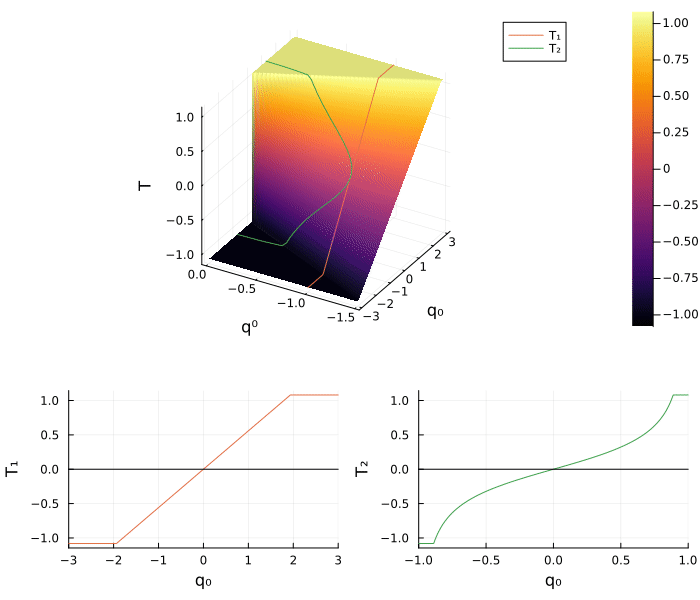

In [10]:
p₀(p) = [p[1], p[2] + p[1]*tf]                                      # function p₀(⋅)
Aₓ = A[2,2]; Bₓ = B[2]                                              # Aₓ and Bₓ
yT = Aₓ*xT + Bₓ                                                     # target in the new coordinate 
T(q) = Aₓ*(S ∘ p₀)(transpose(A)*q)                                  # state flow in the new coordinates
T₁(q) = T([-1, q])                                                # normalization 1
T₂(q) = abs(q) < 1 ? T([η(q), q]) : sign(q)*(Aₓ*tf + Bₓ)          # normalization 2

# Plot
plt_S1 = plot(range(-3, 3, 500), T₁ , color = 2)
plot!([-3,3], [yT,yT], color = :black)
plot!(xlabel = "q₀", ylabel = "T₁", xlim = [-3,3], legend=false)

plt_S2 = plot(range(-1, 1, 500), T₂, color = 3)
plot!([-1,1], [yT,yT], color = :black)
plot!(xlabel = "q₀", ylabel = "T₂", xlim = [-1,1], legend=false)

T_(q⁰, q) = T([q⁰, q])
plt_S = surface(range(0, -1.5, 100), range(-3, 3, 100), T_, camera = (30,30))
surface!(xlabel = "q⁰", ylabel = "q₀", zlabel = "T", xflip = true)
plot3d!(-1*ones(100), range(-3, 3, 100), T₁.(range(-3, 3, 100)), label = "T₁")
plot3d!(η.(range(-1, 1, 100)), range(-1, 1, 100), T₂.(range(-1, 1, 100)), label = "T₂")

plt_S12 = plot(plt_S1, plt_S2, layout = (1,2))
plt_total = plot(plt_S, plt_S12, layout = grid(2,1, heights = [2/3, 1/3]), size=(700, 600))

@gif for i ∈ [range(30, 90, 50); 90*ones(25); range(90, 30, 50); 30*ones(25)]
    plot!(plt_total[1], camera=(i,i), 
        zticks = i==90 ? false : true,
        zlabel = i==90 ? "" : "T" )
end

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     3.223430e-01     0.000000e+00         0.066000
     2     7.034101e-02     1.406250e-01         4.149000
     3     1.135104e-02     1.095650e-02         0.001000
     4     1.033639e-04     4.056828e-04         0.000000
     5     2.155036e-08     3.426091e-08         0.000000
     6     1.679618e-16     1.489880e-15         0.001000
     7     1.679618e-16     9.050305e-32         0.000000
     8     2.155036e-08     1.489880e-15         0.000000
     9     1.679618e-16     1.489880e-15         0.001000
    10     5.387591e-09     9.311753e-17         0.001000
    11     1.679618e-16     9.311753e-17         0.000000
    12     1.346897e-09     5.819847e-18         0.001000
    13     1.679618e-16     5.819847e-18         0.000000
    14     3.367246e-10     3.637407e-19         0.000000
    15     1.679618e-16     3.637407e-19         0.000000
    16     8.418146

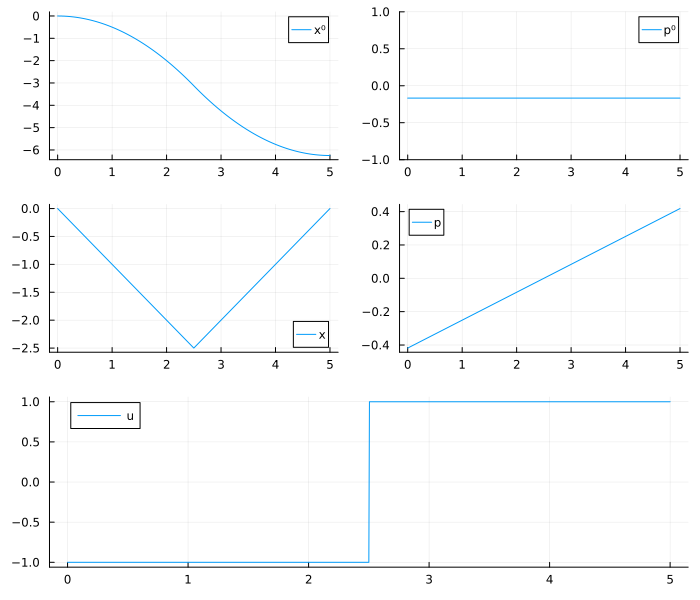

In [11]:
global iterate_T2 = Vector{Float64}()                       # global vector to store iterates of the solver

function T₂!(t₂, ξ)                                         # intermediate function
     push!(iterate_T2, ξ[1])  
     return (t₂[:] .= T₂(ξ[1]); nothing)                   
end

JT₂(ξ) = ForwardDiff.jacobian(q0 -> [T₂(q0[1])], ξ)         # compute jacobian by forward differentiation
JT₂!(jt₂, ξ) = (jt₂[:] .= JT₂(ξ); nothing)                  # intermediate function

ξ = [0.5]                                                   # initial guess
q_sol = fsolve(T₂!, JT₂!, ξ, show_trace = true)             # solve
println(q_sol)                                              # print solution
p0_sol = p₀(transpose(A)*[η(q_sol.x[1]), q_sol.x[1]])       # get the optimal initial costate in old coordinates
sol = ϕ((t0, tf), x0, p0_sol, saveat=range(t0, tf, 500))    # get optimal trajectory

# plot
t = sol.t
x⁰ = [sol.u[i][1] for i in 1:length(sol.u)]
x  = [sol.u[i][2] for i in 1:length(sol.u)]
p⁰ = [sol.u[i][3] for i in 1:length(sol.u)]
p  = [sol.u[i][4] for i in 1:length(sol.u)]
u = sign.(p)

plt_x⁰ = plot(t, x⁰, label = "x⁰")
plt_x  = plot(t, x , label = "x" )
plt_p⁰ = plot(t, p⁰, label = "p⁰", ylim=[-1,1])
plt_p  = plot(t, p , label = "p" )
plt_u  = plot(t, u,  label = "u" )

plt_xp = plot(plt_x⁰, plt_p⁰, plt_x, plt_p, layout=(2, 2))
plot(plt_xp, plt_u, layout = grid(2,1, heights = [2/3, 1/3]), size=(700, 600))

It is shown in [mettre article] that if the boundary of augmented accessible set is the fitted ellipse then the shooting function $T_2$ is the identity function. Due to the error of the approximation, the function $T_2$ is not the identity, but we hope that this function is close to this ideal function, and so that the convergence of $T_2$ is faster than the one of $S_2$. 

The following code compares the convergence of these two shooting function. We also study for these functions the domain of initial guesses for the solver that hit the bounds $[-1, 1]$ during the solving process. 

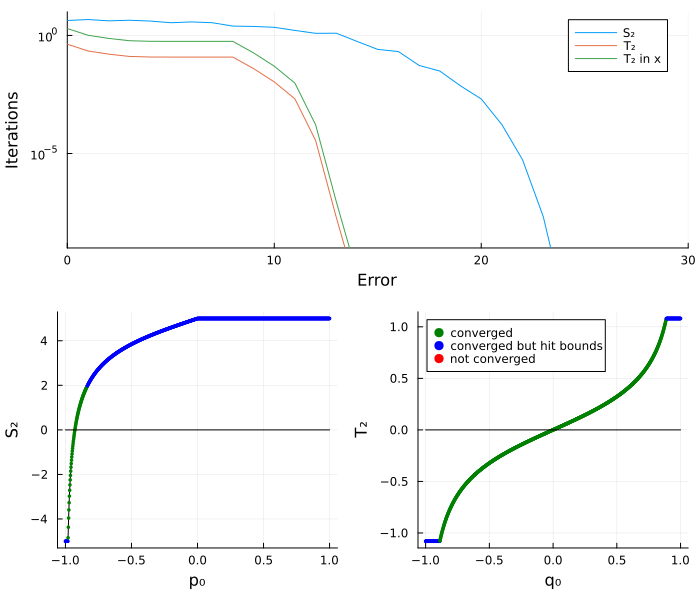

In [13]:
## initial guesses
N = 1000; ξ = range(-1.,1.,N)                               

# initialization of the matrix
fnorms_S2 = zeros(N, 100); fnorms_T2 = zeros(N, 100)        
fnorms_T2_in_x = zeros(N, 100)
iterates_S2 = zeros(N, 100); iterates_T2 = zeros(N, 100)
conv_S2 = zeros(N,1); conv_T2 = zeros(N,1)                  
#-1 : not converged; 1 converged; 0: converged but hit bounds

# intermediate function to get value of S from T iterates
T₂_(q0) = abs(q0) < 1 ? S(p₀(transpose(A)*[η.(q0),q0])) : sign(q0) * tf - xT

for i = 1:N
    # remove old iterates
    global iterate_S2 = Vector{Float64}()
    global iterate_T2 = Vector{Float64}()

    # solve 
    q_sol_S2 = fsolve(S₂!, JS₂!, [ξ[i]], show_trace = false, tracing = true)
    q_sol_T2 = fsolve(T₂!, JT₂!, [ξ[i]], show_trace = false, tracing = true)
    

    # store results is converged 
    if q_sol_S2.converged
        fnorm_S2 = [q_sol_S2.trace.trace[j].fnorm for j ∈ 1:length(q_sol_S2.trace.trace)]
        iterates_S2[i,1:length(iterate_S2)] = iterate_S2
        conv_S2[i] = length(findall(x-> abs(x) > 1, iterate_S2)) == 0
        fnorms_S2[i,1:length(fnorm_S2)] = fnorm_S2
    else
        conv_S2[i] = -1
    end
    if q_sol_T2.converged
        fnorm_T2 = [q_sol_T2.trace.trace[j].fnorm for j ∈ 1:length(q_sol_T2.trace.trace)]
        iterates_T2[i,1:length(iterate_T2)] = iterate_T2
        conv_T2[i] = length(findall(x-> abs(x) > 1, iterate_T2)) == 0
        fnorms_T2[i,1:length(fnorm_T2)] = fnorm_T2 
        fnorms_T2_in_x[i, 1:length(iterate_T2)] = abs.(T₂_.(iterate_T2))
    else
        conv_T2[i] = -1
    end
end

# mean 
mean_fnorms_S2 = mean(fnorms_S2, dims = 1)
mean_fnorms_T2 = mean(fnorms_T2, dims = 1)
mean_fnorms_T2_in_x = mean(fnorms_T2_in_x, dims = 1)

# remove zeros with tolerance ε 
ε = 1e-9;
mean_fnorms_S2 = mean_fnorms_S2[1:findall(x -> x < ε, mean_fnorms_S2)[1][2]]
mean_fnorms_T2 = mean_fnorms_T2[1:findall(x -> x < ε, mean_fnorms_T2)[1][2]]
mean_fnorms_T2_in_x = mean_fnorms_T2_in_x[1:findall(x -> x < ε, mean_fnorms_T2_in_x)[1][2]]

# plots
plt_1 = plot(0:length(mean_fnorms_S2)-1, mean_fnorms_S2, label = "S₂")
plot!(0:length(mean_fnorms_T2)-1, mean_fnorms_T2, label = "T₂")
plot!(0:length(mean_fnorms_T2_in_x)-1, mean_fnorms_T2_in_x, label = "T₂ in x")
plot!(yaxis = :log10, xlim = [0, 30], ylim = [ε, 10], xlabel = "Error", ylabel = "Iterations")

plt_21 = plot(ξ, S₂, color = :black, label = "")
color = [conv_S2[i]==1 ? :green : conv_S2[i] == 0 ? :blue : :red for i ∈ 1:N]
scatter!(ξ, S₂, color = color, markerstrokecolor = color, marker = 2, label ="")
plot!([-1,1], [xT,xT], color = :black, label = "")
plot!(xlabel = "p₀", ylabel = "S₂", label = "")

plt_22 = plot(ξ, T₂, color = :black, label = "")
color = [conv_T2[i]==1 ? :green : conv_T2[i] == 0 ? :blue : :red for i ∈ 1:N]
scatter!(ξ, T₂, markercolor = color, markerstrokecolor = color, marker = 2, label = "")
plot!([-1,1], [yT,yT], color = :black, label = "")
plot!(xlabel = "q₀", ylabel = "T₂", label = "")
scatter!(1,1, markercolor = :green, markerstrokecolor = :green, marker = 2, label = "converged")
scatter!(1,1, markercolor = :blue, markerstrokecolor = :blue, marker = 2, label = "converged but hit bounds")
scatter!(1,1, markercolor = :red, markerstrokecolor = :red, marker = 2, label = "not converged")

plt_2 = plot(plt_21, plt_22, layout = (1,2))
plot(plt_1, plt_2, layout = grid(2,1, heights = [0.5, 0.5]), size=(700, 600))